### MNIST データセット

In [0]:
import numpy as np
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(X_train.shape) # (60000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(X_train[0].dtype) # uint8
print(X_train[0])

(60000, 28, 28)
(10000, 28, 28)
uint8
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0 

### 平滑化

In [0]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

### 画像データの可視化

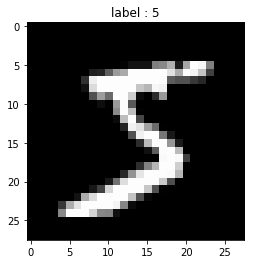

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
index = 0
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

### 前処理

In [5]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [6]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64
print(X_train.shape)

(60000,)
(60000, 10)
float64
(60000, 784)


In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

(48000, 784)
(12000, 784)


# 【問題1】ニューラルネットワーク分類器のクラスを作成  

In [0]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder       # ワンホットのやつ
from tqdm import tqdm                                                     # 進捗バーを出してくれるやつ

class ScratchSimpleNeuralNetworkClassifier():
    """
    シンプルな三層ニューラルネットワーク分類器

    Parameters
    ----------
    verbose : bool
        学習過程を出力する場合はTrue
    epochs : int
        エポック数（イテレーション数）
    batch_size : int
        バッチサイズ

    Attributes
    ----------
    self.loss_ : dict
        イテレーションごとのcostとaccuracy
    """

    def __init__(self, batch_size=10, n_epochs=10,  n_nodes1=400, n_nodes2=200, sigma=1e-2, lr=1e-2, verbose=False):
        self.batch_size = batch_size     # バッチサイズ
        self.n_epochs = n_epochs         # エポック数 
        self.n_nodes1 = n_nodes1        # 1層目のノード数
        self.n_nodes2 = n_nodes2        # 2層目のノード数
        self.sigma = sigma                      # ガウス分布の標準偏差
        self.lr = lr                                      # 学習率
        self.verbose = verbose               # 学習過程出力フラグ
        self.n_features = None              # 特徴量の数
        self.n_output = None                 # 出力のクラス数
        self.W1 = None                           # 層ごとの重さ格納用
        self.W2 = None
        self.W3 = None
        self.B1 = None                            # 層ごとのバイアス格納用
        self.B2 = None
        self.B3 = None
        self.loss_ = []                             # 学習用データの学習過程格納用
        self.loss_val_ = []                     # 検証用データの学習過程格納用
        # ワンホットライブラリのインスタンス作成
        self.enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
    
    
    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """
        
        # ワンホット化
        y = self.enc.fit_transform(y[:, np.newaxis])
        
        # 検証用データがある場合
        if X_val is not None:
            y_val= self.enc.fit_transform(y_val[:, np.newaxis])
        
        # 学習用データから特徴量とクラス数を取得
        self.n_features = X.shape[1]
        self.n_output = y.shape[1]

        # 重み・バイアスの初期化 (*1=一層目, *2=二層目, ...
        self.W1 = self.sigma * np.random.randn(self.n_features, self.n_nodes1)
        self.B1 = self.sigma * np.random.randn(self.n_nodes1)
        self.W2 = self.sigma * np.random.randn(self.n_nodes1, self.n_nodes2)
        self.B2 = self.sigma * np.random.randn(self.n_nodes2)
        self.W3 = self.sigma * np.random.randn(self.n_nodes2, self.n_output)
        self.B3 = self.sigma * np.random.randn(self.n_output)
        
        # エポックごとに進捗率を計測
        for i in tqdm(range(self.n_epochs)):
            # ミニバッチ化
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
            
            # Xのn_samples / batch_size数分ループ処理
            for mini_X_train, mini_y_train in get_mini_batch:
                                            
                #フォワードプロパゲーション
                A1, Z1, A2, Z2, A3, Z3= self._forward_propagation(mini_X_train)
                
                #バックプロパゲーション                
                dW1, dB1, dW2, dB2, dW3, dB3 = self._back_propagation(
                    mini_X_train, mini_y_train, A1, Z1, A2, Z2, A3, Z3)
                
                # パラメータ更新
                self.W1 -= self.lr * dW1
                self.B1 -= self.lr * dB1
                self.W2 -= self.lr * dW2
                self.B2 -= self.lr * dB2
                self.W3 -= self.lr * dW3
                self.B3 -= self.lr * dB3
                
            
            # エポックごと学習完了時の予測値を計算
            _, _, _, _, _, Z3= self._forward_propagation(X)
            
            # 交差エントロピー誤差を計算
            loss = cross_entropy(y, Z3)
            
            # 誤差を格納
            self.loss_.append(loss)
            
            # 検証用データがある場合
            if X_val is not None:
                # 学習用と同じように誤差を計算〜格納まで行う
                _, _, _, _, _, Z3= self._forward_propagation(X_val)
                
                loss_val = cross_entropy(y_val, Z3)

                self.loss_val_.append(loss_val)
            
            if self.verbose:
                print('{}エポック目 ： {}  (学習用データ)'.format(i, loss))
                if X_val is not None:
                    print('{}エポック目 ： {}  (検証用データ)'.format(i, loss_val))
                    
        return self


    def _forward_propagation(self, X):
        """
        フォワードプロパゲーションの計算

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習データ

        Returns
        -------
         
        """
        
        #1層目
        A1 = (X @ self.W1) + self.B1
        Z1 = sigmoid(A1)

        #2層目
        A2 = (Z1 @ self.W2) + self.B2
        Z2 = sigmoid(A2)

        #3層目
        A3 = (Z2 @ self.W3) + self.B3
        Z3 = softmax(A3)
        
        return A1, Z1, A2, Z2, A3, Z3
    
    
    def _back_propagation(self, X, y, A1, Z1, A2, Z2, A3, Z3):
        """
        バックプロパゲーションの計算

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習データ

        Returns
        -------
         次の形のndarray, shape (batch_size, n_nodes)
            sigmoid計算結果
        """
        
        #3層目
        dZ3 = Z3 - y
        dW3 = Z2.T @ dZ3 / len(X)
        dB3 = np.mean(dZ3, axis=0)

        #2層目
        dZ2 = (dZ3 @ self.W3.T) * sigmoid_derivative(A2)
        dW2 = Z1.T @ dZ2
        dB2 = np.mean(dZ2, axis=0)

        #1層目
        dZ1 = (dZ2 @ self.W2.T) * sigmoid_derivative(A1)
        dW1 = X.T @ dZ1
        dB1 = np.mean(dZ1, axis=0)
        
        return dW1, dB1, dW2, dB2, dW3, dB3

    

    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習データ

        Returns
        -------
        y_pred :  次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        # フォワードプロパゲーション
        _, _, _, _, _, Z3= self._forward_propagation(X)
        
        # 一番確率が高いラベルを予測値に
        y_pred = np.argmax(Z3, axis=1)
        
        return y_pred
    
    
    
    
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

-　関数たち

In [0]:
def sigmoid(X):
    sigmoid_range = 34.538776394910684     # 入力の最大値
    return 1 / (1 + np.exp(-np.clip(X, -sigmoid_range, sigmoid_range)))


def sigmoid_derivative(X):
    return sigmoid(X) * (1 - sigmoid(X))


def softmax(X):
    max_X = np.max(X)
    exp_X = np.exp(X - max_X)
    sum_exp_X = np.sum(exp_X, axis=1).reshape(-1, 1)
    return exp_X / sum_exp_X


def cross_entropy(y_true, y_pred):
    return (-1) * np.sum(y_true * np.log(y_pred))

In [10]:
ssnnc = ScratchSimpleNeuralNetworkClassifier()
ssnnc.fit(X_train, y_train, X_val, y_val)

100%|██████████| 10/10 [04:05<00:00, 24.22s/it]


# 【問題2】学習曲線のプロット

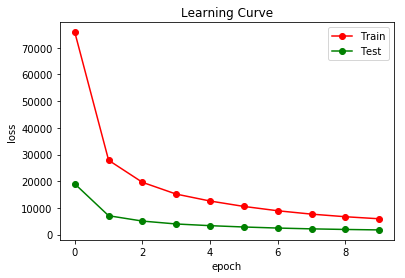

In [24]:
train_loss = np.array(ssnnc.loss_)
test_loss = np.array(ssnnc.loss_val_)

plt.figure()
plt.title("Learning Curve")
plt.xlabel("epoch")
plt.ylabel("loss")

# Traing score と Test score をプロット
plt.plot(train_loss, 'o-', color="r", label="Train")
plt.plot(test_loss, 'o-', color="g", label="Test")

plt.legend(loc=1)
plt.show()

# 【問題3】指標値の算出

In [12]:
# 予測
y_pred = ssnnc.predict(X_val)

print(confusion_matrix(y_val, y_pred))
print(accuracy_score(y_val, y_pred))

[[1101    0    1    0    1    3    7    1    5    2]
 [   0 1304   15    3    3    2    2    2    4    2]
 [   7    1 1156    6    8    0    5    6    3    1]
 [   1    4   16 1160    0   20    2    6    4    3]
 [   2    5    5    0 1164    1    8    3    2   20]
 [  12    0    5   24    7 1020   15    3    9    4]
 [   5    2    3    0    8    7 1152    0    2    0]
 [   0    3   13    5    7    0    0 1279    0    8]
 [  10    5   11   20    7   15    8    4 1053   10]
 [   4    1    2    9   30    7    1   24    7 1102]]
0.9575833333333333


### 落書き

In [18]:
import numpy as np
import time

A = np.array([[1, 2, 3],[4,5,6]])
B = np.array([[3,6,9],[5,1,2]])


start = time.time()
AB = np.dot(A, B.T)
process_time = time.time() - start
print(process_time)

start = time.time()
AB = A @ B.T
process_time = time.time() - start

print(process_time)
# @でもそんな変わんなそうというか早い？

8.654594421386719e-05
7.677078247070312e-05


## TODO
- 1エポックあたり20秒くらいかかっちゃってる  
→ 次のsprintで直す